In [1]:
import sys, os
sys.path.append(os.getcwd())   # เพิ่ม current dir ลง sys.path
import MPI
import MPI_collective

In [2]:
from qiskit_aer import Aer
import MPI_collective
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
# from qiskit import IBMQ, execute, assemble, Aer

import numpy as np
# from convert import *
aer_sim = Aer.get_backend('aer_simulator')
# aer_sim = AerSimulator()
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
# import testCases
import math

# from qiskit.tools.monitor import job_monitor
import qiskit
from supermarq import *
from cirq.contrib.qasm_import import circuit_from_qasm
from qiskit_ibm_runtime.fake_provider import *

c:\Users\DELL\Desktop\code\quantum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%run MPI.py
%run MPI_collective.py

In [4]:
backend_list = [
    FakeAlgiers(),
    FakeAlmadenV2(),
    FakeArmonkV2(),
    FakeAthensV2(),
    FakeAuckland(),
    FakeBelemV2(),
    FakeBoeblingenV2(),
    FakeBogotaV2(),
    FakeBrisbane(),
    FakeBrooklynV2(),
    FakeBurlingtonV2(),
    FakeCairoV2(),
    FakeCambridgeV2(),
    FakeCasablancaV2(),
    FakeCusco(),
    FakeEssexV2(),
    FakeFractionalBackend(),
    FakeGeneva(),
    FakeGuadalupeV2(),
    FakeHanoiV2(),
    FakeJakartaV2(),
    FakeJohannesburgV2(),
    FakeKawasaki(),
    FakeKolkataV2(),
    FakeKyiv(),
    FakeKyoto(),
    FakeLagosV2(),
    FakeLimaV2(),
    FakeLondonV2(),
    FakeManhattanV2(),
    FakeManilaV2(),
    FakeMelbourneV2(),
    FakeMontrealV2(),
    FakeMumbaiV2(),
    FakeNairobiV2(),
    FakeOsaka(),
    FakeOslo(),
    FakeOurenseV2(),
    FakeParisV2(),
    FakePeekskill(),
    FakePerth(),
    FakePoughkeepsieV2(),
    FakePrague(),
    FakeQuebec(),
    FakeQuitoV2(),
    FakeRochesterV2(),
    FakeRomeV2(),
    FakeSantiagoV2(),
    FakeSherbrooke(),
    FakeSingaporeV2(),
    FakeSydneyV2(),
    FakeTorino(),
    FakeTorontoV2(),
    FakeValenciaV2(),
    FakeVigoV2(),
    FakeWashingtonV2(),
    FakeYorktownV2(),
]

In [5]:
results = []
two_qubit_gates = [
    'cx', 'cz', 'cy', 'swap', 'iswap', 'ecr', 'rxx', 'ryy', 'rzz',
    'ms', 'ch', 'cp', 'crx', 'cry', 'crz'
]
optimization_levels = [0, 1, 2, 3]

def transpile_circuit(qc, results):
	for backend in backend_list:
		backend_name = backend.name
		for level in optimization_levels:
			try:
				# Transpile a circuit
				transpiled_circuit = transpile(qc, backend=backend, optimization_level=level)

				# นับจำนวน 2-qubit gates (ในตัวอย่างนี้คือ 'cx')
				# คุณสามารถเพิ่มชื่อเกต 2-qubit อื่นๆ ได้ตามต้องการ เช่น 'cz', 'swap'
				ops_counts = transpiled_circuit.count_ops()

				# รวมจำนวนของเกต 2 คิวบิตทั้งหมดจากลิสต์ด้านบน
				two_qubit_gate_count = sum(ops_counts.get(gate, 0) for gate in two_qubit_gates)

				# เก็บผลลัพธ์
				results.append({
					'backend': backend_name,
					'level': level,
					'2_qubit_gate_count': two_qubit_gate_count
				})
				print(f"✅ Transpiled สำเร็จ: Backend={backend_name}, Level={level}, 2-Qubit Gates={two_qubit_gate_count}")

			except Exception as e:
				# หากเกิด error ให้ข้ามไป
				print(f"❌ Transpiled ไม่สำเร็จ: Backend={backend_name}, Level={level}. Error: {e}")
				continue
	return results

def plotting(results, str):
	"""
	ฟังก์ชันสำหรับพล็อต Grouped Bar Chart จากผลลัพธ์การ transpile
	แก้ไขให้รองรับกรณีที่การ transpile บาง level ล้มเหลวได้
	"""
	if not results:
		print("\nไม่สามารถสร้างกราฟได้เนื่องจากไม่มีผลลัพธ์จากการ transpile")
		return

	# --- เริ่มส่วนที่แก้ไข ---

	# 1. จัดโครงสร้างข้อมูลใหม่โดยใช้ Nested Dictionary
	# โครงสร้าง: {'backend_name': {level_0: count, level_1: count, ...}, ...}
	# วิธีนี้จะป้องกันข้อมูลผิดตำแหน่งเมื่อ transpile บาง level ล้มเหลว
	plot_data = {}
	for r in results:
		backend = r['backend']
		level = r['level']
		count = r['2_qubit_gate_count']

		if backend not in plot_data:
			plot_data[backend] = {}
		plot_data[backend][level] = count

	# ดึงชื่อ backend และ level (เรียงลำดับเพื่อให้แน่ใจว่าถูกต้อง)
	backend_names = sorted(plot_data.keys())
	optimization_levels = [0, 1, 2, 3]
	n_levels = len(optimization_levels)

	# 2. ตั้งค่าการพล็อต
	x = np.arange(len(backend_names))
	bar_width = 0.2
	fig, ax = plt.subplots(figsize=(25, 11)) #ปรับขนาดให้เหมาะสม

	# 3. วนลูปเพื่อวาดกราฟทีละ Level
	for i, level in enumerate(optimization_levels):
		# !! ส่วนสำคัญที่แก้ไข !!
		# ดึงข้อมูลโดยใช้ .get(level, 0)
		# หมายความว่า "พยายามดึงข้อมูลของ level นี้ ถ้าไม่มี (เพราะ transpile ล้มเหลว) ให้ใช้ค่า 0"
		counts_for_level = [plot_data[b].get(level, 0) for b in backend_names]

		# คำนวณตำแหน่งของแท่งกราฟสำหรับ level ปัจจุบัน
		position = x - (bar_width * (n_levels - 1) / 2) + (i * bar_width)

		# วาดแท่งกราฟและเพิ่มตัวเลขกำกับ
		bars = ax.bar(position, counts_for_level, bar_width, label=f'Level {level}')
		ax.bar_label(bars, padding=3, fontsize=8)


	# 4. ตกแต่งกราฟให้สวยงาม
	ax.set_ylabel('Number of 2-Qubit Gates', fontsize=14)
	ax.set_xlabel('Backend', fontsize=14)
	ax.set_title(f'2-Qubit Gate Count after Transpilation ({str})', fontsize=16)

	# ตั้งค่าแกน X
	ax.set_xticks(x)
	ax.set_xticklabels(backend_names, rotation=45, ha="right")
	ax.set_ylim(top=ax.get_ylim()[1] * 1.1) # เพิ่มพื้นที่ด้านบนของกราฟเล็กน้อย

	# เพิ่ม Legend
	ax.legend(title='Optimization Level', fontsize=12)

	ax.grid(axis='y', linestyle='--', alpha=0.7)
	fig.tight_layout()

	plt.show()

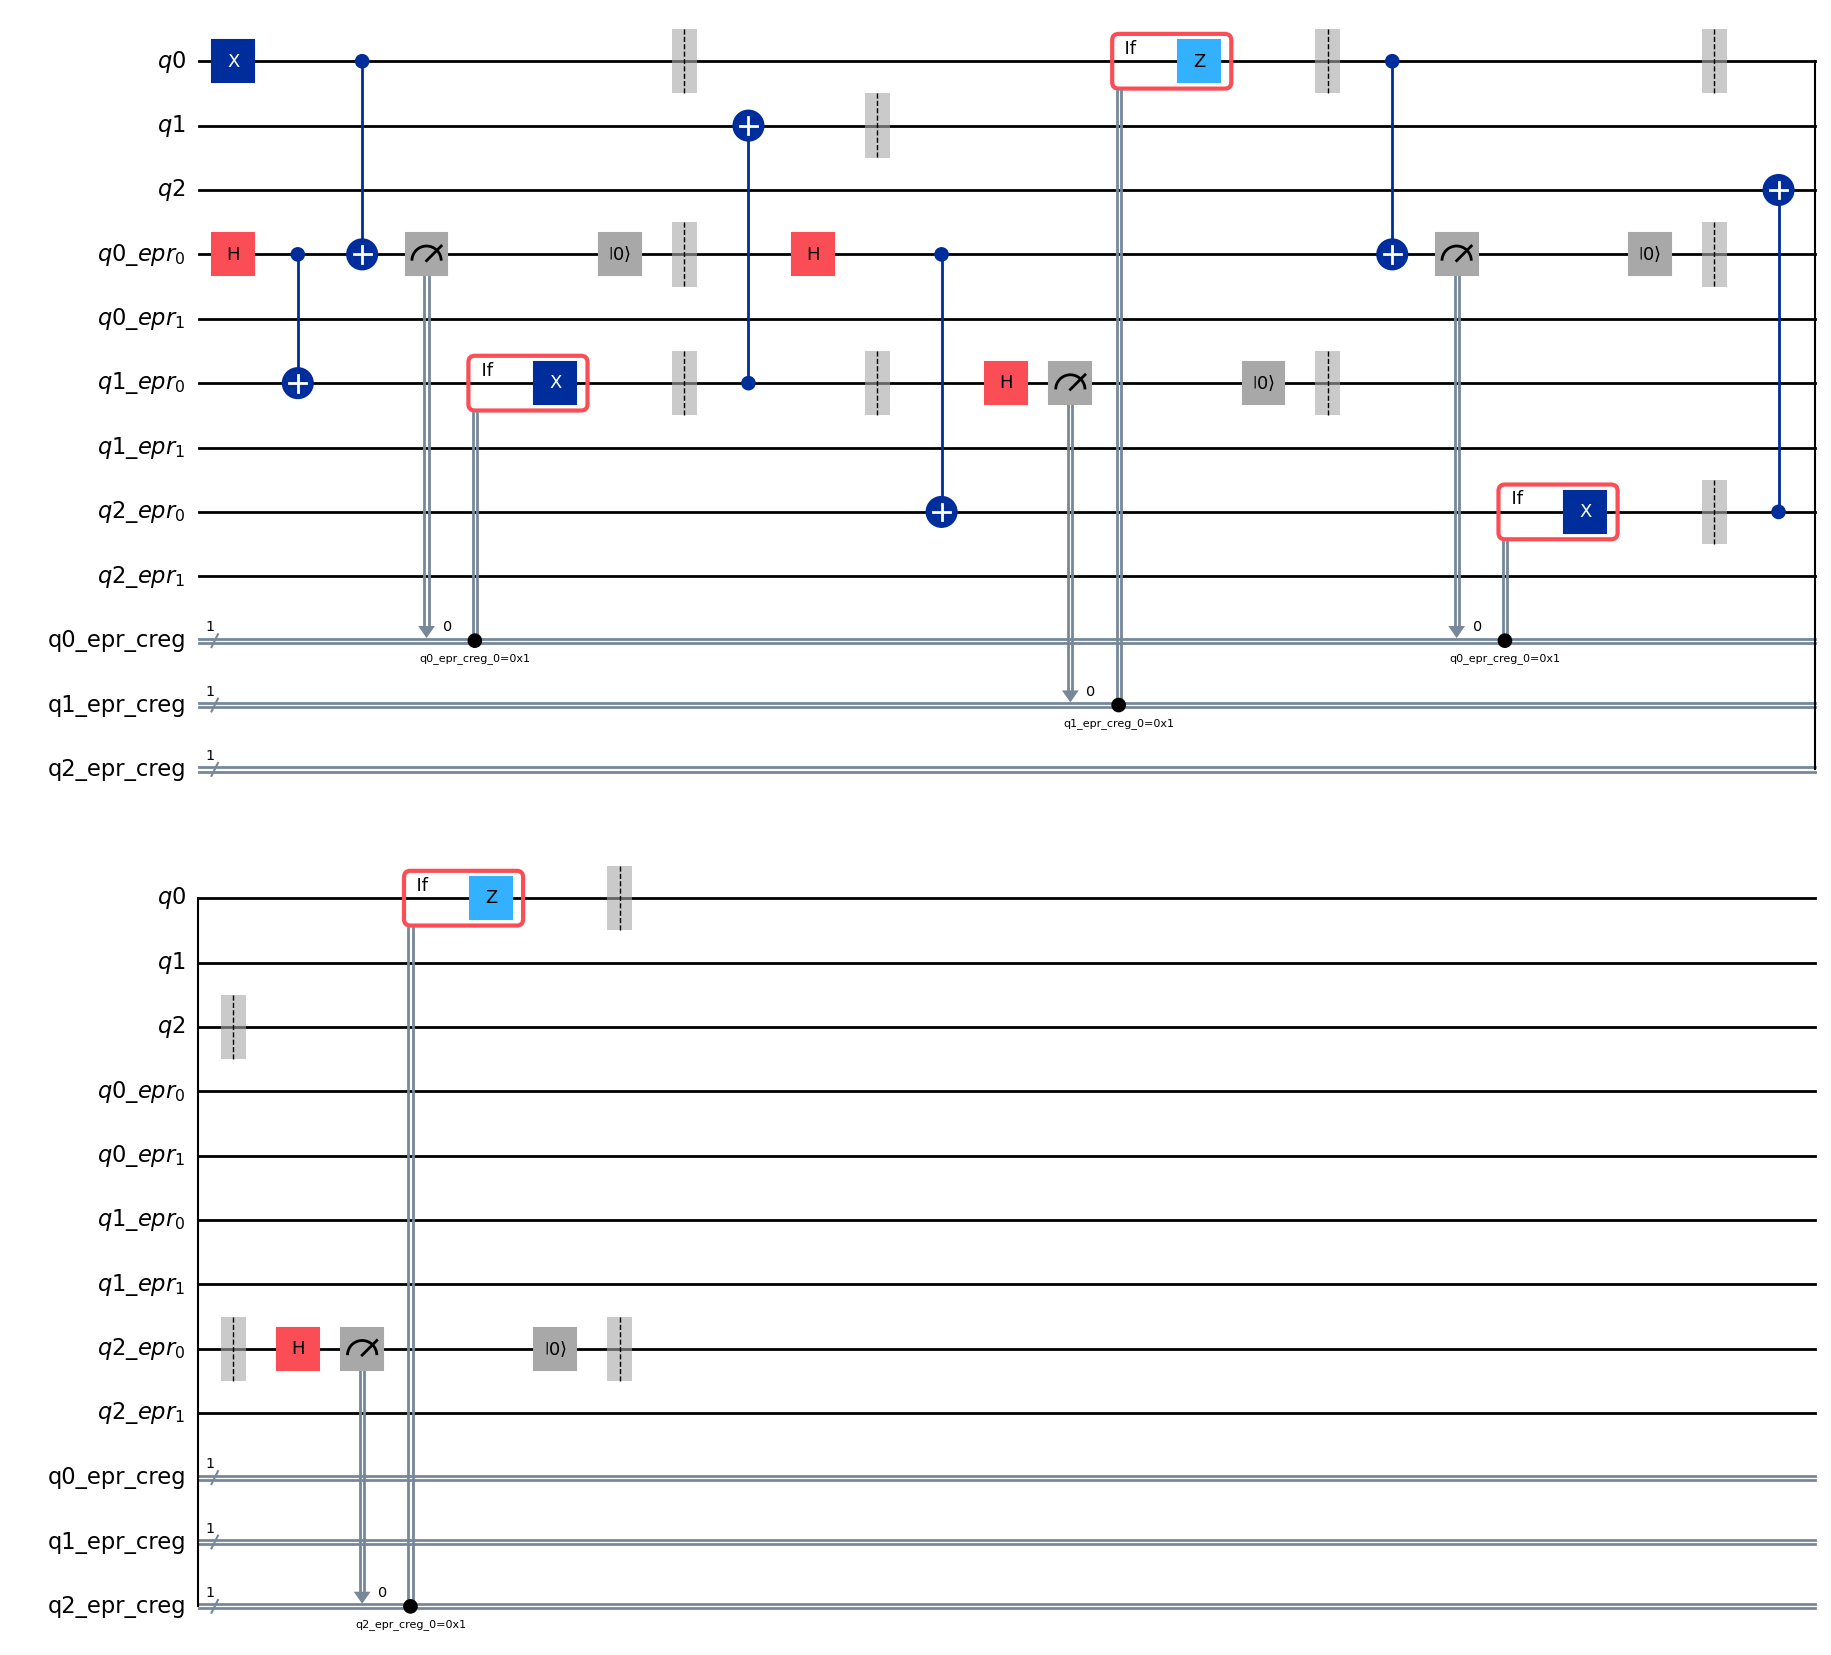

In [6]:
N = 3  # node
qregs = [QuantumRegister(1, f"q{i}") for i in range(N)]
qc = QuantumCircuit(*qregs)

# |1> at (q0)
qc.x(qregs[0][0])

# ==== 2) CollectiveMPI
coll = MPI_collective.CollectiveMPI(qc)

# broadcast q0 -> q1,q2
coll.broadcast([qregs[0][0], qregs[1][0], qregs[2][0]])

# # ==== 3) unbroadcast
#for i in range(1, N):
#    epr = MPI.EPRsetup(qc, qregs[0][0], qregs[i][0], n=1)
#    instrs = epr.uncopy()
#    for instr, qargs, cargs in instrs:
#        qc.append(instr, qargs, cargs)

qc.draw("mpl")

✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=0, 2-Qubit Gates=33
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=1, 2-Qubit Gates=6
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=2, 2-Qubit Gates=6
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=3, 2-Qubit Gates=6
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=0. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=1. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=2. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=3. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_armonk, Level=0. Error: 'Number of qubits (9) in circuit-171 is greater than maximum (1) in the coupling_map'
❌ Transpiled ไม่สำเร็จ: Backend=fake_armonk,

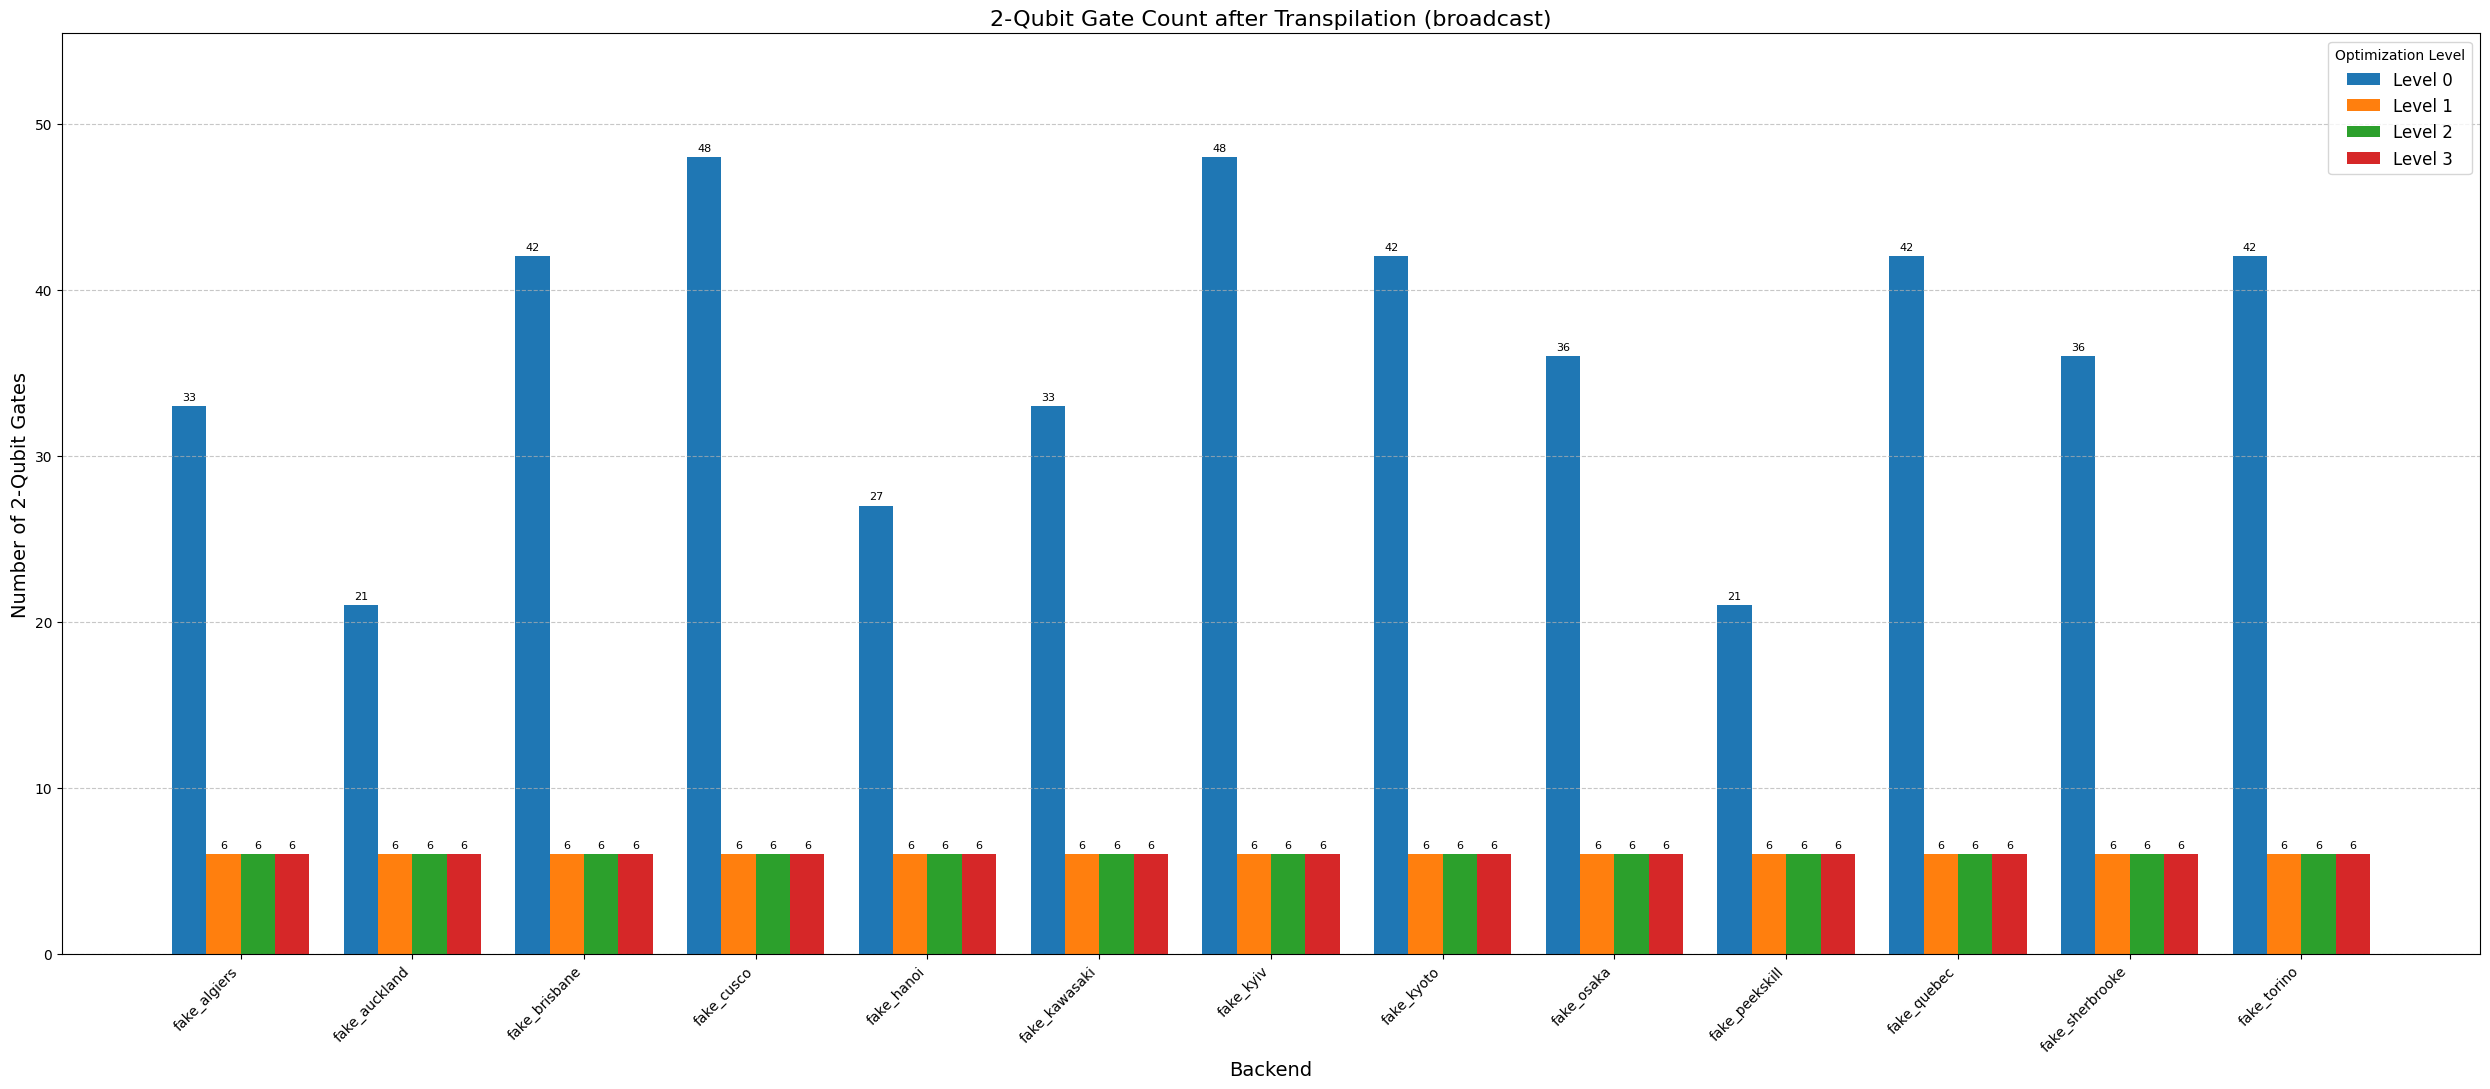

In [7]:
plotting(transpile_circuit(qc, results), "broadcast")

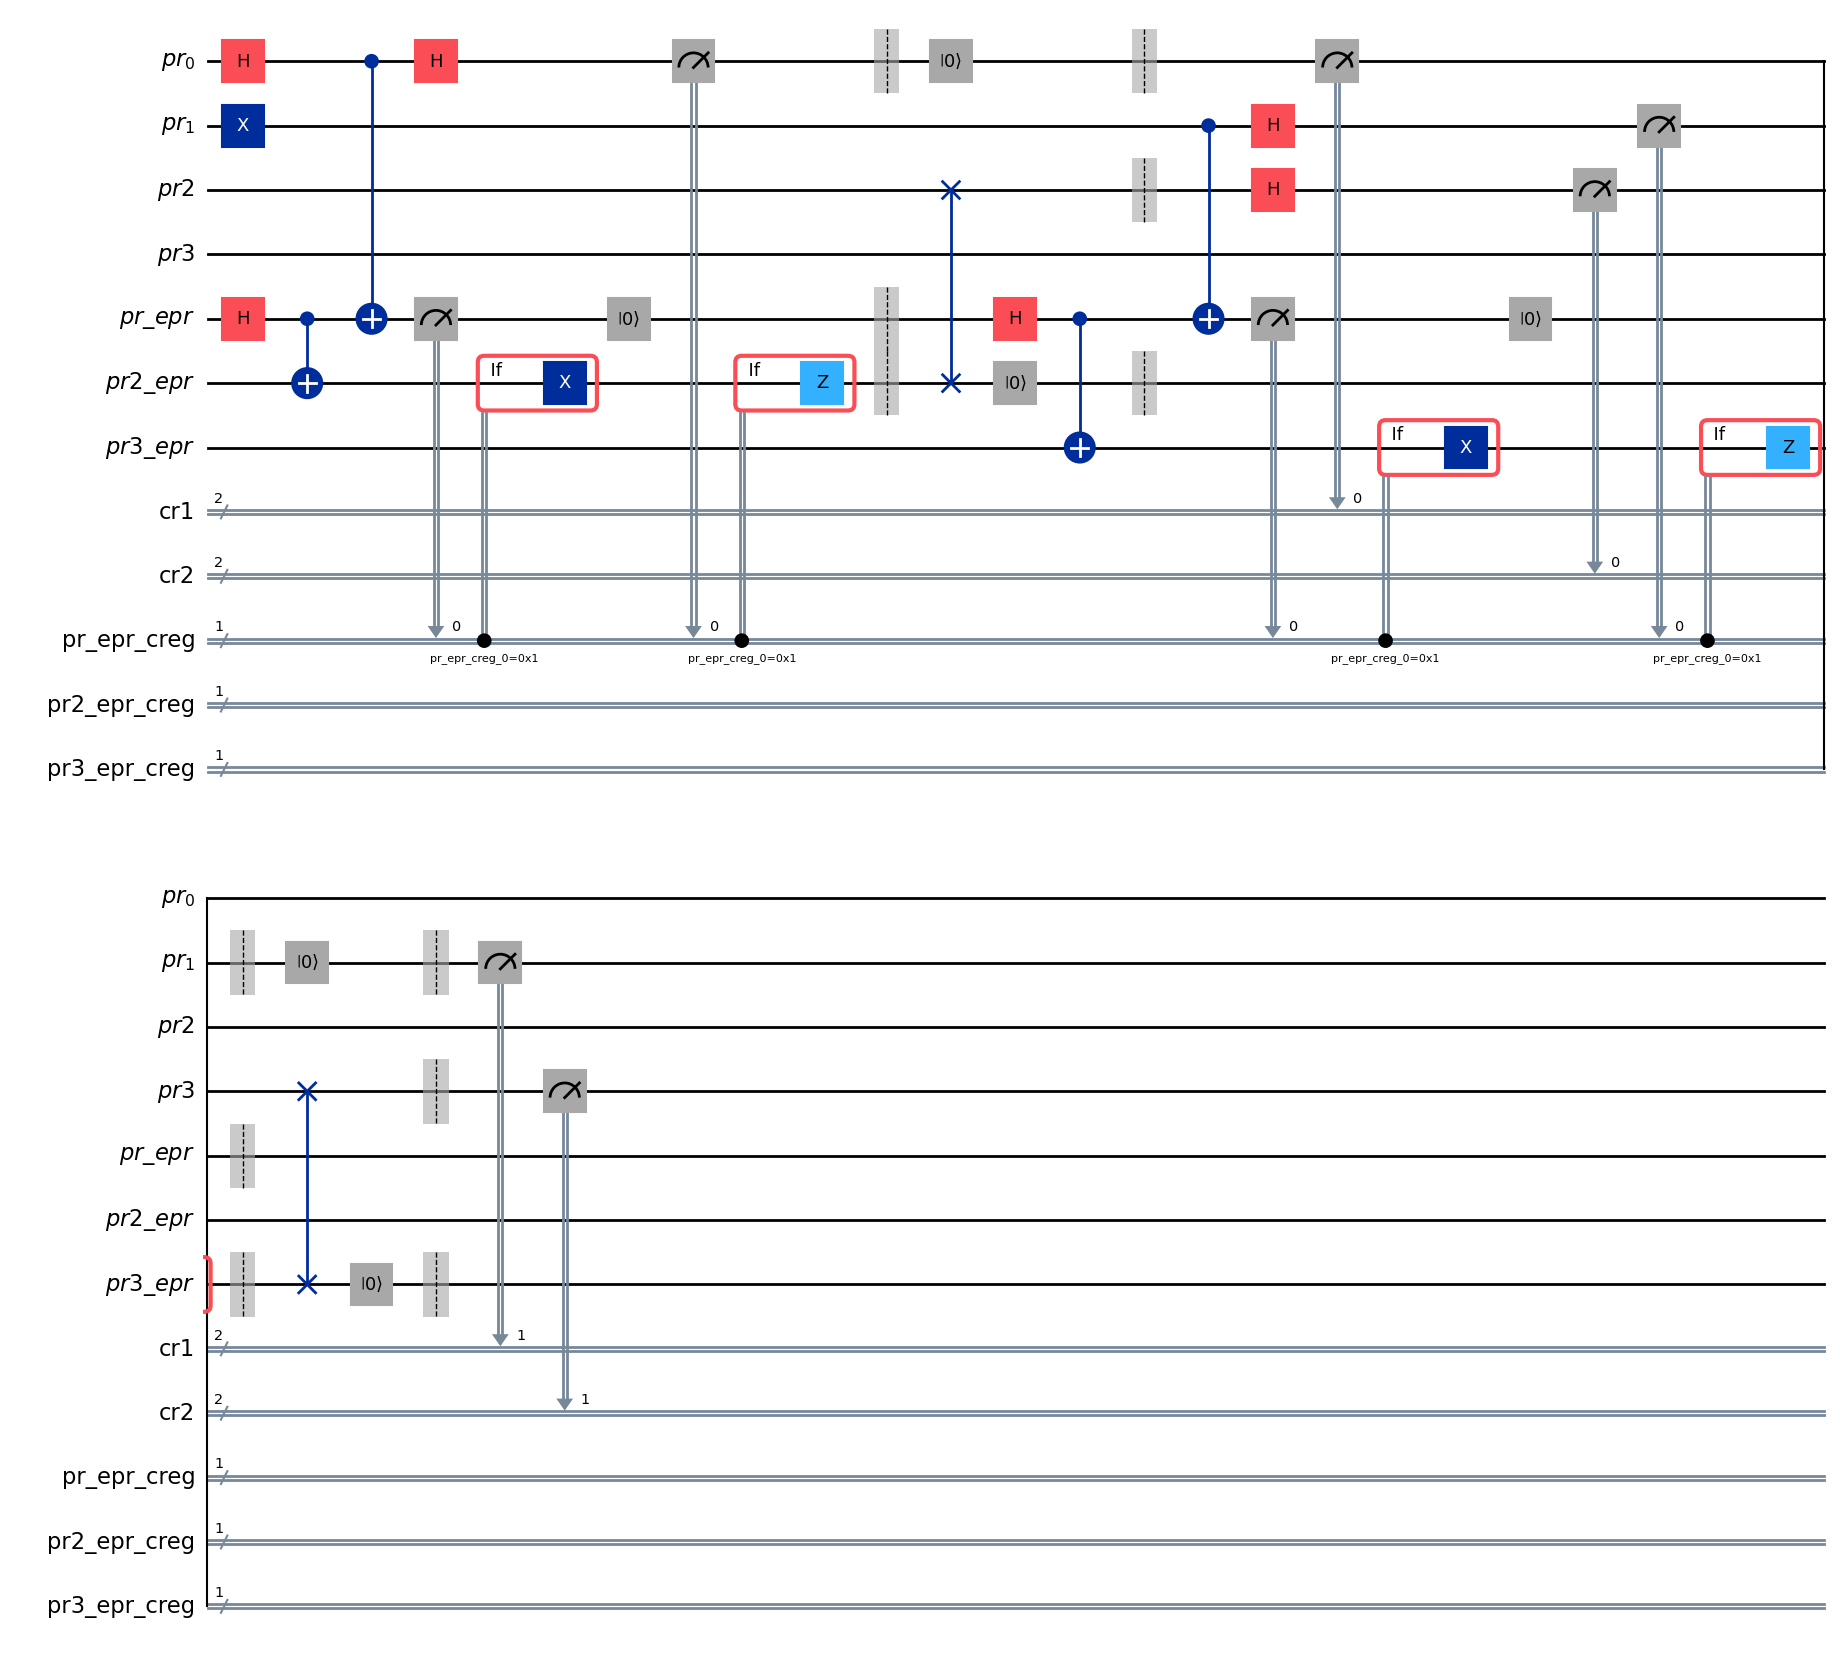

In [8]:
# check out scatter
pp = QuantumCircuit()
pr = QuantumRegister(2, 'pr')
pr2 = QuantumRegister(1, 'pr2')
pr3 = QuantumRegister(1, 'pr3')
cr1 = ClassicalRegister(2, 'cr1')
cr2 = ClassicalRegister(2, 'cr2')
pp.add_register(pr,pr2,pr3,cr1,cr2)
pp.h(pr[0])
pp.x(pr[1])
m = MPI_collective.CollectiveMPI(pp, pr, n=1)
m.scatter([pr[0], pr[1]], [pr2[0],pr3[0]])
pp.h(pr2[0])
pp.measure([pr[0],pr[1], pr2[0],pr3[0]], [cr1[0],cr1[1], cr2[0],cr2[1]])
pp.draw('mpl')

✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=0, 2-Qubit Gates=34
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=1, 2-Qubit Gates=16
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=2, 2-Qubit Gates=7
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=3, 2-Qubit Gates=7
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=0. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=1. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=2. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=3. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_armonk, Level=0. Error: 'Number of qubits (7) in circuit-2061 is greater than maximum (1) in the coupling_map'
❌ Transpiled ไม่สำเร็จ: Backend=fake_armon

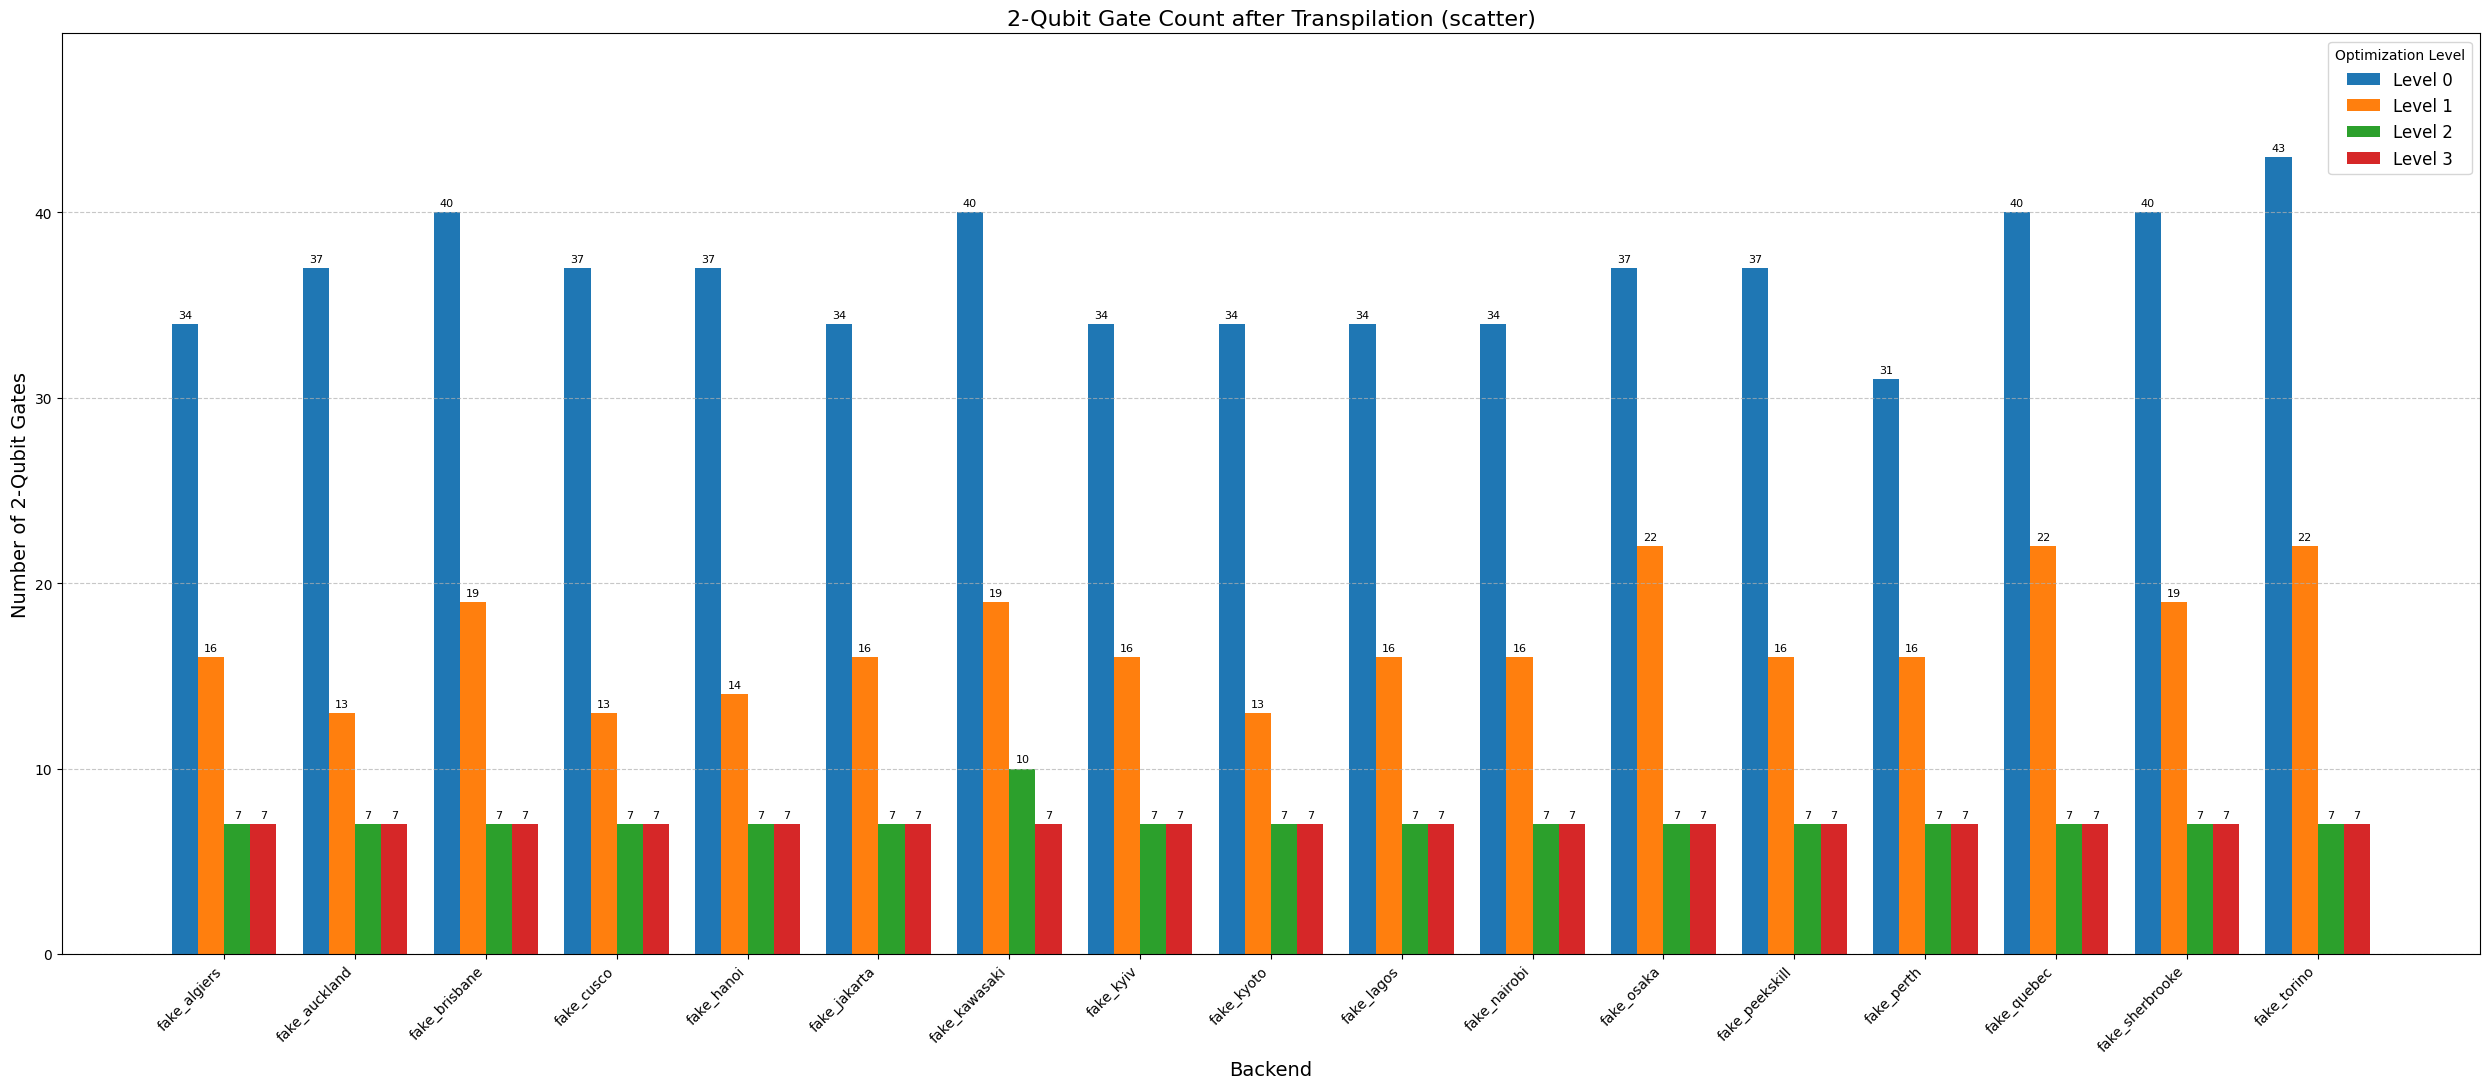

In [9]:
plotting(transpile_circuit(pp, results), "scatter")

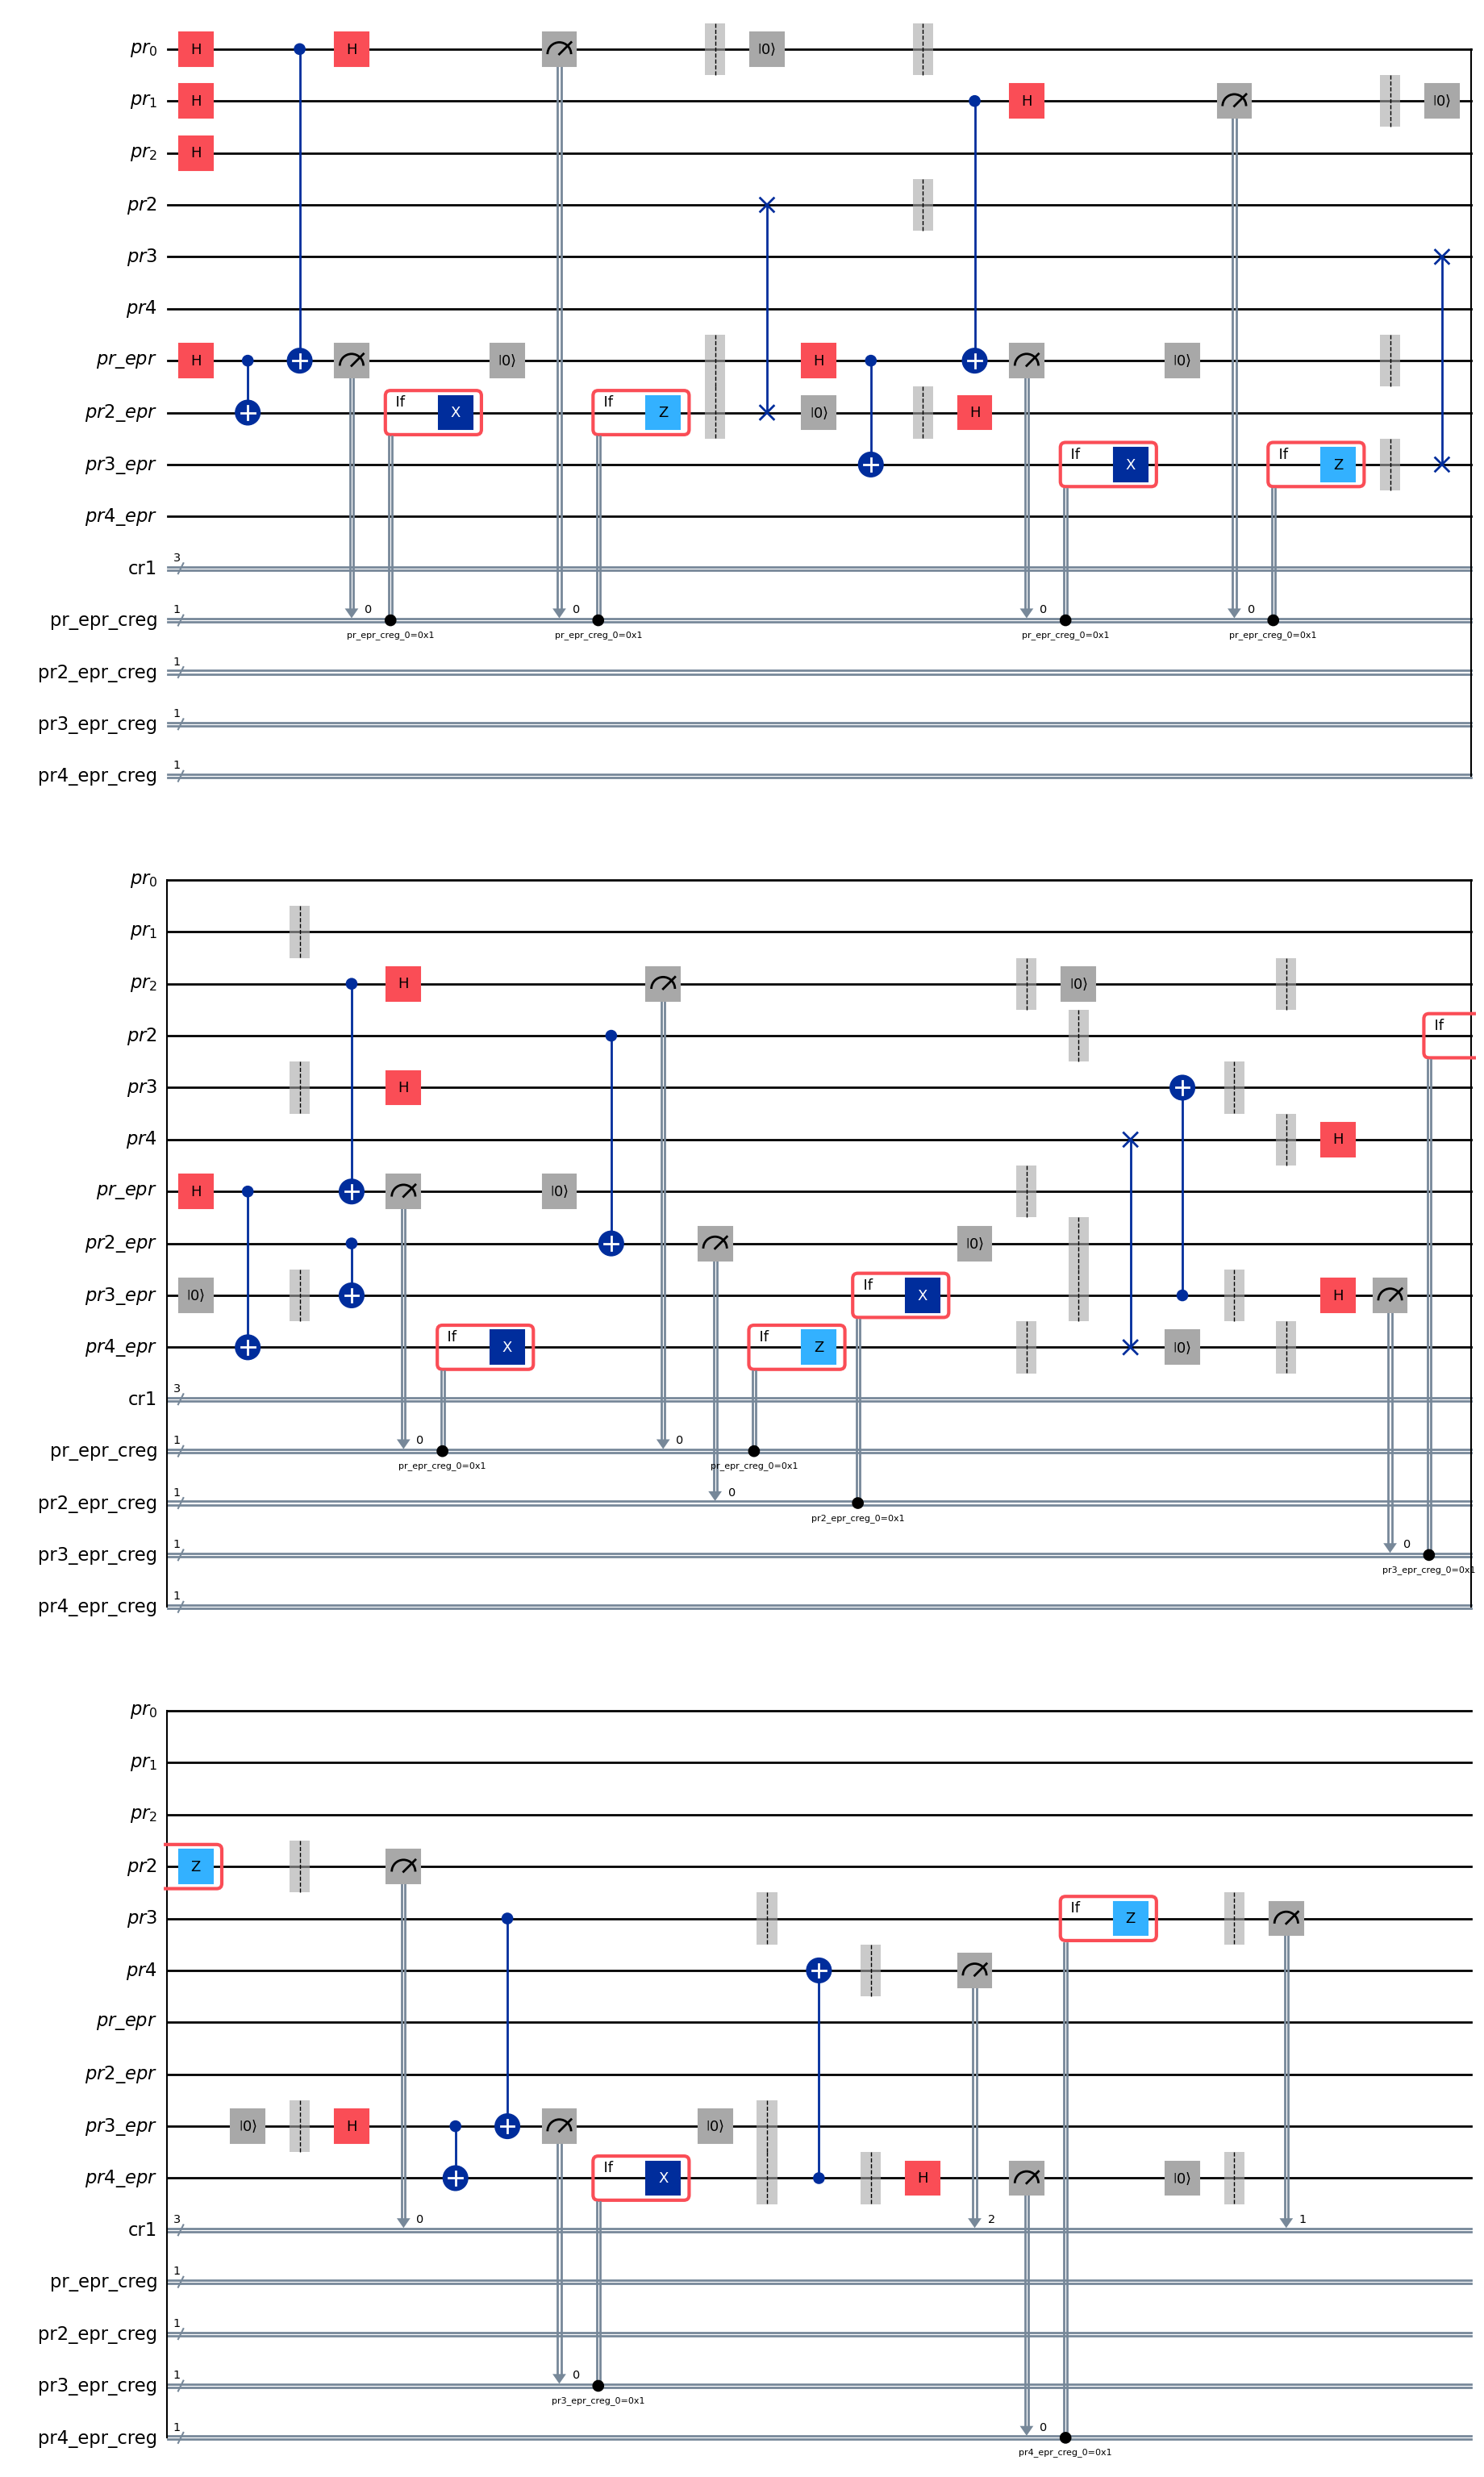

In [10]:
# check out sequential reduce
pp = QuantumCircuit()
pr = QuantumRegister(3, 'pr')
pr2 = QuantumRegister(1, 'pr2')
pr3 = QuantumRegister(1, 'pr3')
pr4 = QuantumRegister(1, 'pr4')
cr1 = ClassicalRegister(3, 'cr1')
pp.add_register(pr,pr2,pr3,pr4,cr1)
pp.h([pr[0],pr[1], pr[2]])
m = MPI_collective.CollectiveMPI(pp, pr, n=1)
m.scatter([pr[0], pr[1], pr[2]], [pr2[0],pr3[0], pr4[0]])

ppp = QuantumCircuit(2)
ppp.h(1)
ppp.cx(0, 1)

m.sequentialReduce([pr2[0], pr3[0], pr4[0]], ppp)
#pp.h(pr2[0])
pp.measure([pr2[0],pr3[0], pr4[0]], cr1)
pp.draw('mpl')

✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=0, 2-Qubit Gates=99
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=1, 2-Qubit Gates=39
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=2, 2-Qubit Gates=28
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=3, 2-Qubit Gates=30
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=0. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=1. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=2. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=3. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_armonk, Level=0. Error: 'Number of qubits (10) in circuit-4680 is greater than maximum (1) in the coupling_map'
❌ Transpiled ไม่สำเร็จ: Backend=fake_ar

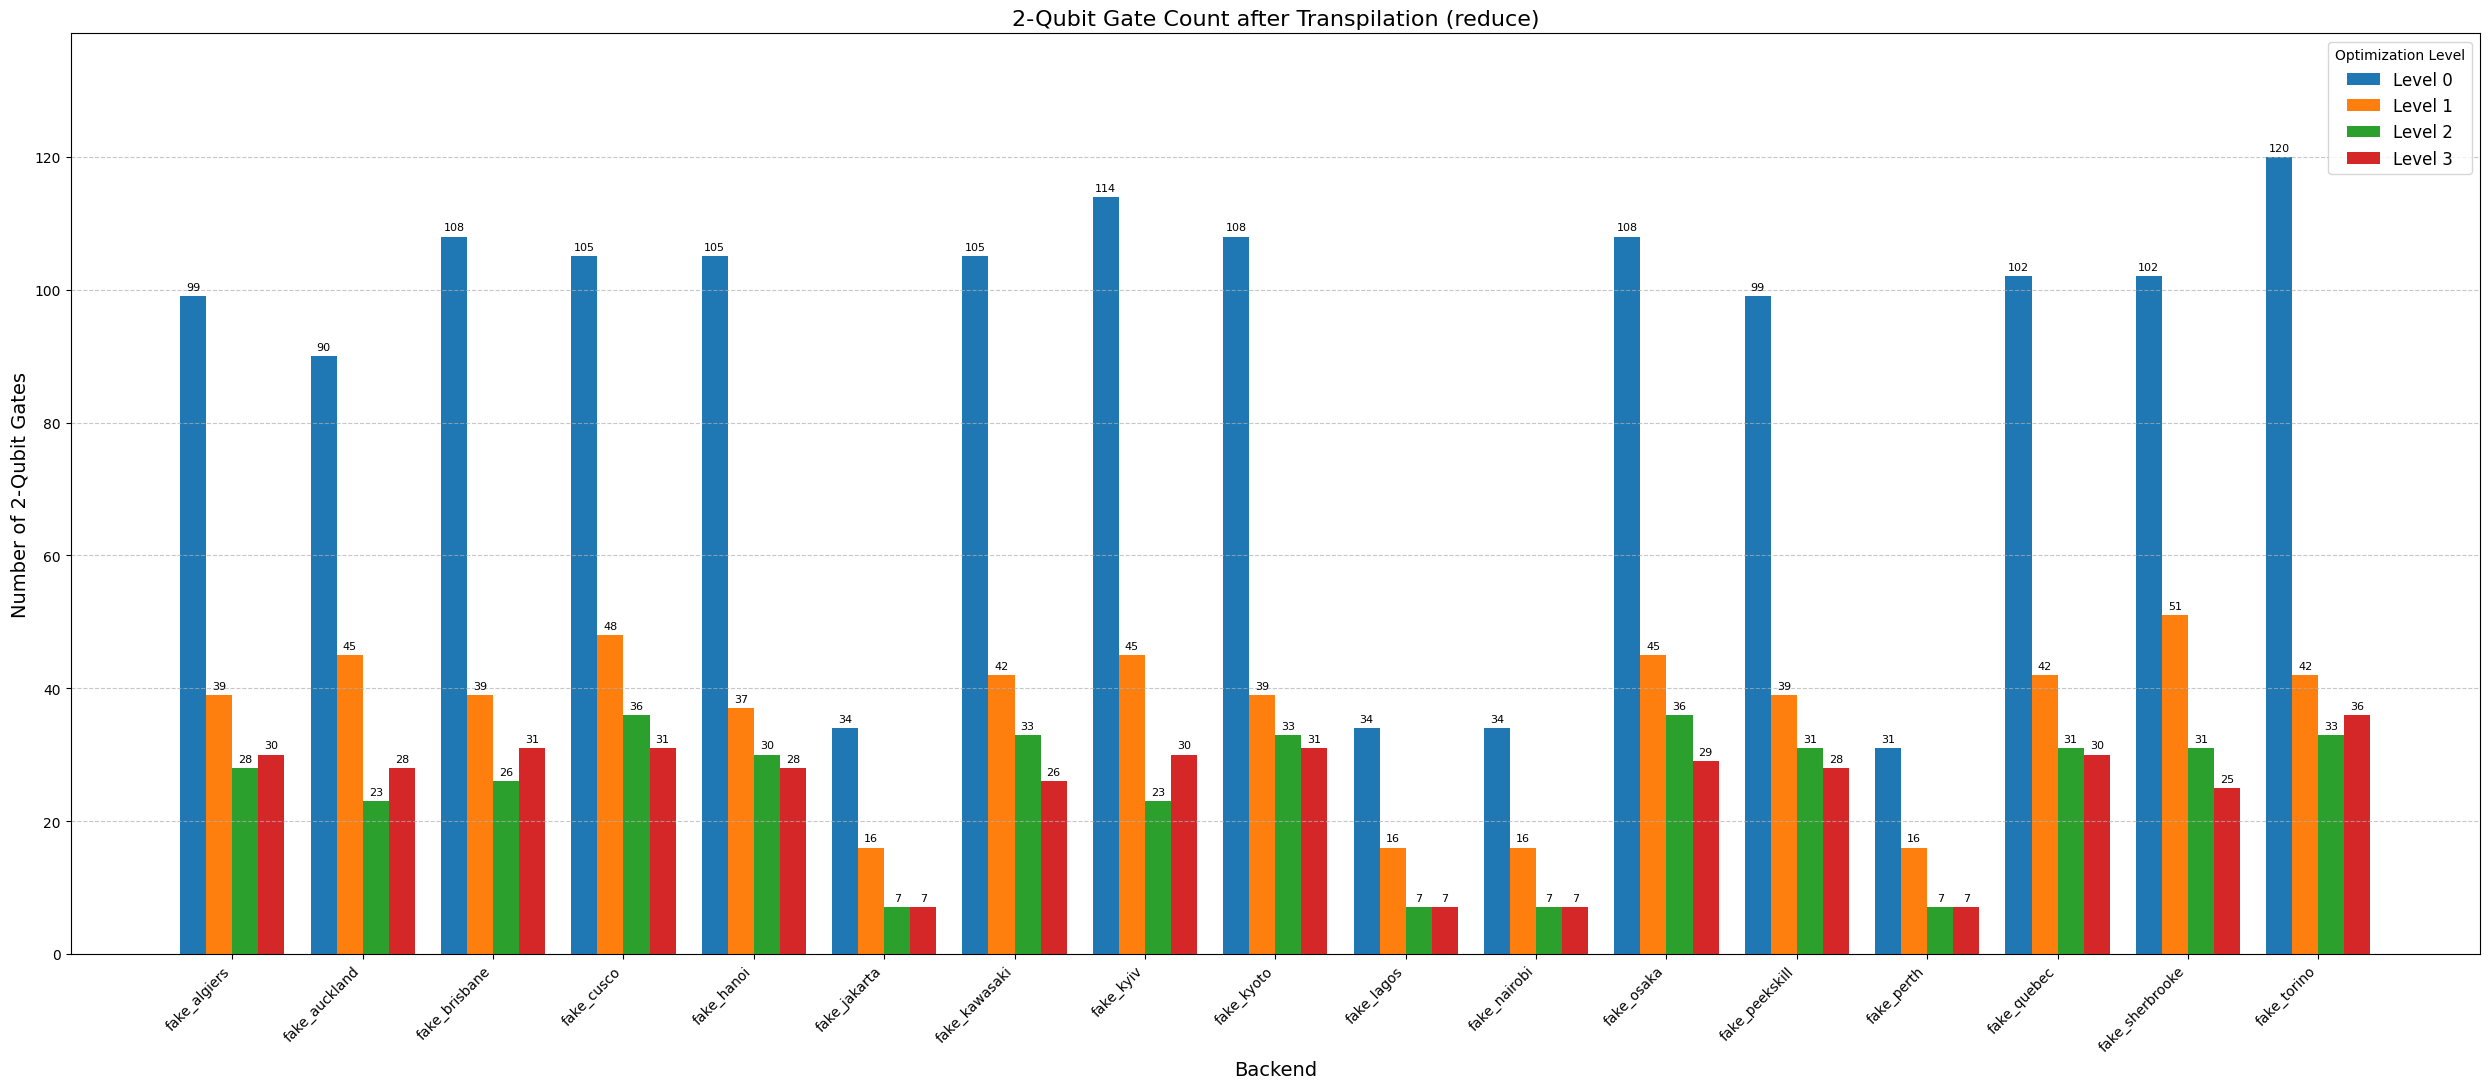

In [11]:
plotting(transpile_circuit(pp, results), "reduce")

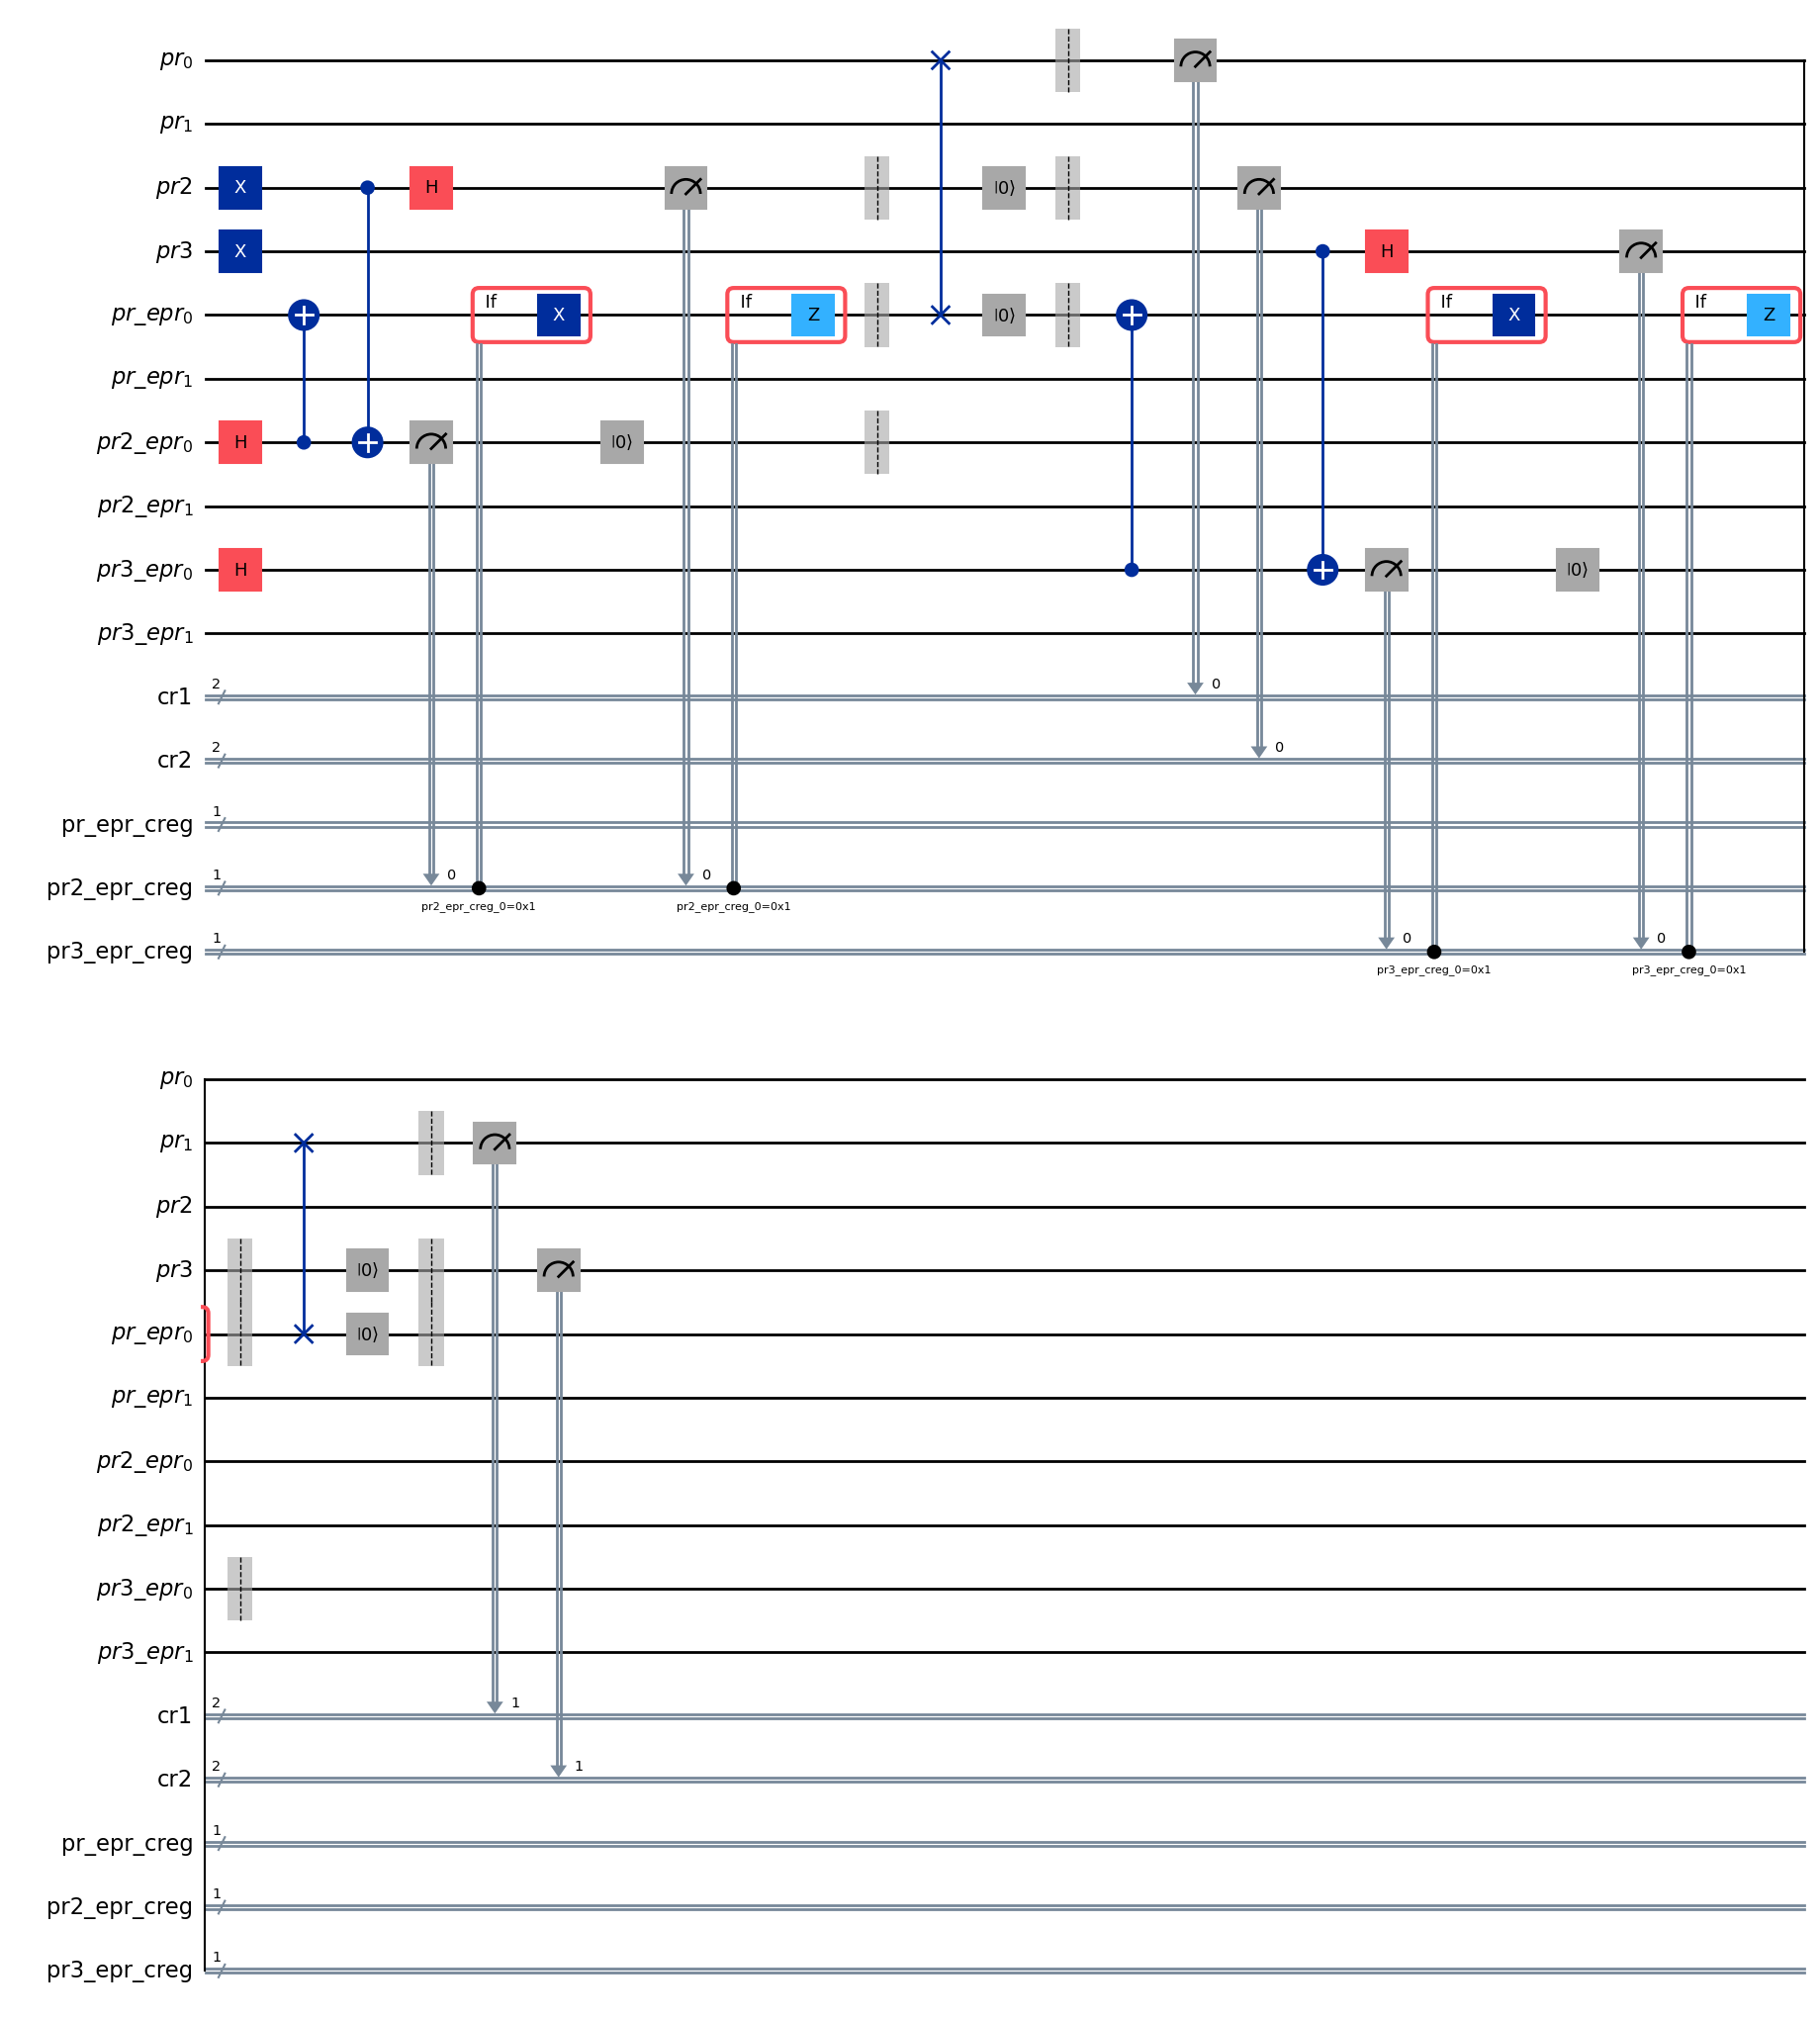

In [12]:
# check out gather
pp = QuantumCircuit()
pr = QuantumRegister(2, 'pr')
pr2 = QuantumRegister(1, 'pr2')
pr3 = QuantumRegister(1, 'pr3')
cr1 = ClassicalRegister(2, 'cr1')
cr2 = ClassicalRegister(2, 'cr2')
cr3 = ClassicalRegister(2, 'cr3')
pp.add_register(pr,pr2,pr3,cr1,cr2)
pp.x(pr2[0])
pp.x(pr3[0])
m = MPI_collective.CollectiveMPI(pp, pr)
m.gather([pr2[0], pr3[0]], [pr[0],pr[1]])
pp.measure([pr[0],pr[1], pr2[0],pr3[0]], [cr1[0],cr1[1], cr2[0],cr2[1]])
pp.draw('mpl')

✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=0, 2-Qubit Gates=37
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=1, 2-Qubit Gates=13
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=2, 2-Qubit Gates=4
✅ Transpiled สำเร็จ: Backend=fake_algiers, Level=3, 2-Qubit Gates=4
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=0. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=1. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=2. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_almaden, Level=3. Error: "The control-flow construct 'if_else' is not supported by the backend."
❌ Transpiled ไม่สำเร็จ: Backend=fake_armonk, Level=0. Error: 'Number of qubits (10) in circuit-9982 is greater than maximum (1) in the coupling_map'
❌ Transpiled ไม่สำเร็จ: Backend=fake_armo

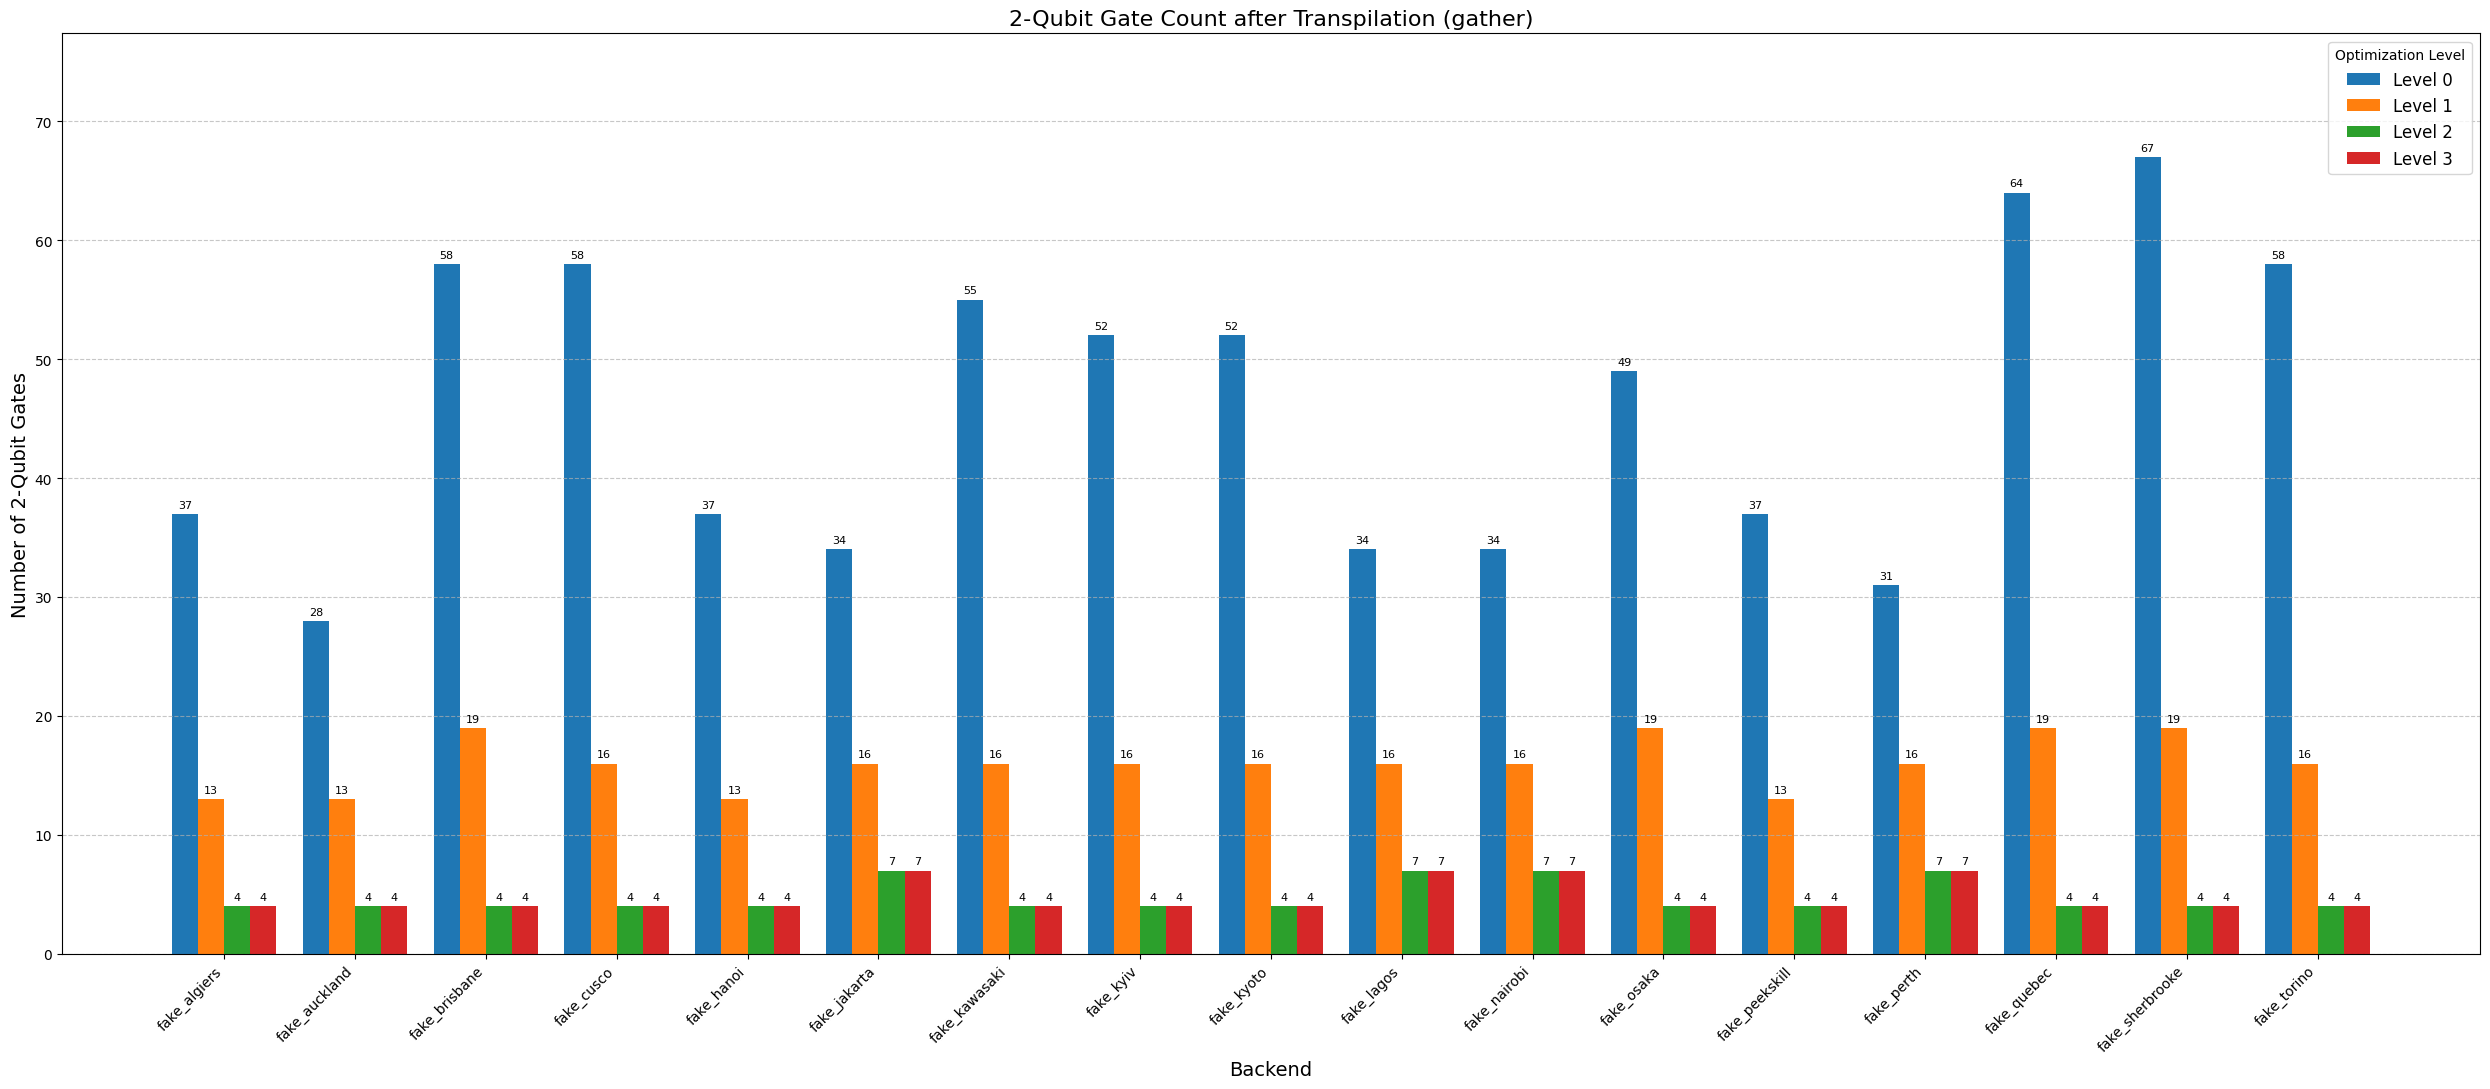

In [13]:
plotting(transpile_circuit(pp, results), "gather")

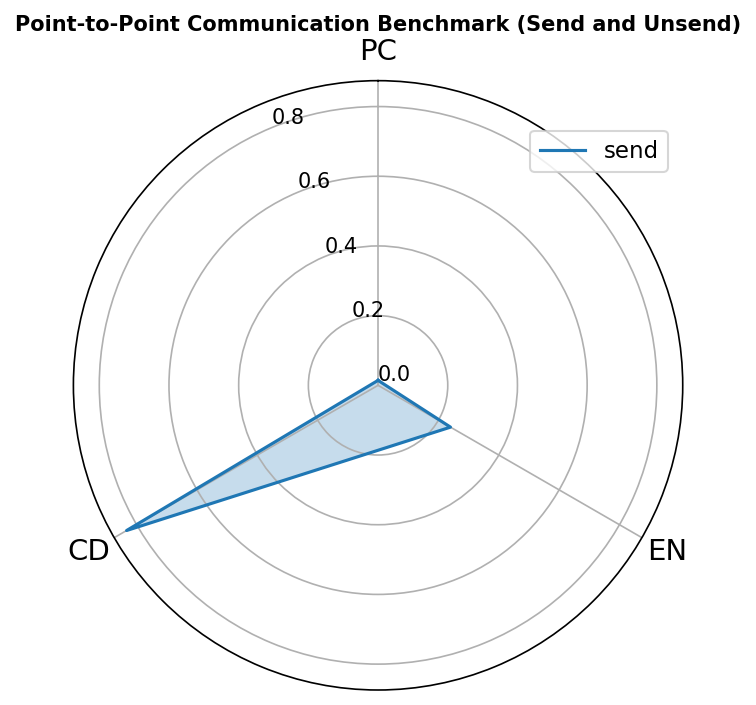

In [76]:
send_feat = [
  converters.compute_communication_with_qiskit(transpiled_circuit),
  converters.compute_depth_with_qiskit(transpiled_circuit),
  converters.compute_entanglement_with_qiskit(transpiled_circuit),
  #converters.compute_liveness_with_qiskit(transpiled_circuit),
  #converters.compute_measurement_with_qiskit(transpiled_circuit),
  #converters.compute_parallelism_with_qiskit(transpiled_circuit)
]

spoke_labels = ["PC", "CD", "EN"]
plotting.plot_benchmark(
    title="Point-to-Point Communication Benchmark (Send and Unsend)",
    labels=["send"],             # one label
    features=[send_feat],        # must be a list of feature lists
    spoke_labels=spoke_labels,
    show=True
)

In [64]:
qc.clear()